In [159]:
from pydub import AudioSegment
import numpy as np
import os
import librosa
import pandas as pd
from pydub.playback import play
import matplotlib.pyplot as plt
from pydub.utils import mediainfo
import numpy, scipy.optimize
from scipy.signal import find_peaks
from scipy import signal


Reading the file:

In [ ]:
FILE_NAME='./sound_of_ball_original.wav'
info = mediainfo(FILE_NAME)
original_sample_rate=int(info['sample_rate'])
sound = AudioSegment.from_file(FILE_NAME)
file_handle = sound.export("sound_of_ball_original_2.wav", format="wav")
samples = sound.get_array_of_samples()
samples_list=samples.tolist()


In [ ]:
def speed_change(sound, speed=1.0):
    # Manually override the frame_rate. This tells the computer how many
    # samples to play per second
    sound_with_altered_frame_rate = sound._spawn(sound.raw_data, overrides={
        "frame_rate": int(sound.frame_rate * speed)
    })

    # convert the sound with altered frame rate to a standard frame rate
    # so that regular playback programs will work right. They often only
    # know how to play audio at standard frame rate (like 44.1k)
    return sound_with_altered_frame_rate.set_frame_rate(sound.frame_rate)

- Get the sample
- Plot it
- Get the most important frequency 
- Plot it low pass filtered sample
- Count the crosses

In [ ]:

one_sample=samples[100000:180000]
short_sound = AudioSegment(one_sample.tobytes(), frame_rate=sound.frame_rate,sample_width=sound.sample_width,channels=1)
file_handle = short_sound.export("short_sound_output.wav", format="wav")
plt.figure(figsize=[20,8])
plt.plot(one_sample)

In [ ]:
rosa_sound, sr=librosa.load(FILE_NAME, sr=int(original_sample_rate))
ft=np.fft.fft(rosa_sound)
ft_mag=np.abs(ft)
# plt.plot(ft_mag[:10000])
ft_mag_list=ft_mag.tolist()
np.argmax(ft_mag_list)

3D Spectrogram:

In [152]:
f, t, Sxx = signal.spectrogram(np.array(one_sample), mode='magnitude')
db=10*np.log10(Sxx)
plt.pcolormesh(t, f, db, shading='auto')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

FTT

In [ ]:
temp_ft=np.fft.fft(samples)
temp_ft_abs=np.abs(temp_ft)
temp_ft_abs=temp_ft_abs[:len(temp_ft_abs)//2]
# plt.plot(temp_ft_abs)
max_index=np.argmax(temp_ft_abs)
len(temp_ft_abs)-max_index #3196
print(max_index)
print(max(temp_ft_abs))
print(temp_ft_abs[max_index])

In [ ]:
f_ratio=0.2
freq_x=np.linspace(0, original_sample_rate, len(ft_mag))
num_freq_bins=int(len(freq_x)* f_ratio)
#plt.plot(freq_x[:num_freq_bins], ft_mag[:num_freq_bins])
# plt.plot([x if x > 3000 else 0 for x in ft_mag[:2000]])

Low pass filter at different frequencies:

In [ ]:
for freq_to_cut_at in range(1, 10, 1):
    new_short_lpf=short_sound.low_pass_filter(freq_to_cut_at)
    plt.figure(figsize=[100,30])
    short_sound_list=short_sound.get_array_of_samples()
    new_short_lpf_list=list(new_short_lpf.get_array_of_samples())
    plt.plot(short_sound_list)
    plt.plot(new_short_lpf_list,color='r')
    ppeaks, _ = find_peaks(new_short_lpf_list)
    npeaks, _ = find_peaks([-x for x in new_short_lpf_list])
    all_peaks=list(ppeaks)+list(npeaks)
    all_peaks.sort()
    true_peaks=[]
    i=1
    for i in range(1,len(true_peaks)-1):
        if np.sign(new_short_lpf_list[all_peaks[i]])!= np.sign(new_short_lpf_list[all_peaks[i-1]]) and np.sign(new_short_lpf_list[all_peaks[i]])!= np.sign(new_short_lpf_list[all_peaks[i+1]]) :
            true_peaks.append(all_peaks[i])
    print('freq_to_cut_at:', freq_to_cut_at, len(true_peaks), 'ppeaks count:', len(ppeaks), ' npeaks count:', len(npeaks))

Smoothing the one sample
idea 1
- keep increasing the smoothing window until peaks find opposite peaks in the function

In [165]:
def sinfunc(t, A, w, p, c):
    return A * numpy.sin(w*t + p) + c
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = numpy.array(tt)
    yy = numpy.array(yy)
    ff = numpy.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(numpy.fft.fft(yy))
    guess_freq = abs(ff[numpy.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = numpy.std(yy) * 2.**0.5
    guess_offset = numpy.mean(yy)
    guess = numpy.array([guess_amp, 2.*numpy.pi*guess_freq, 0., guess_offset])

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*numpy.pi)
    fitfunc = lambda t: A * numpy.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": numpy.max(pcov), "rawres": (guess,popt,pcov)}

Amplitude=1136.4619400901297, Angular freq.=0.004241018146938535, phase=1.212710850777588, offset=-5.521896892849946, Max. Cov.=819.6850610809246


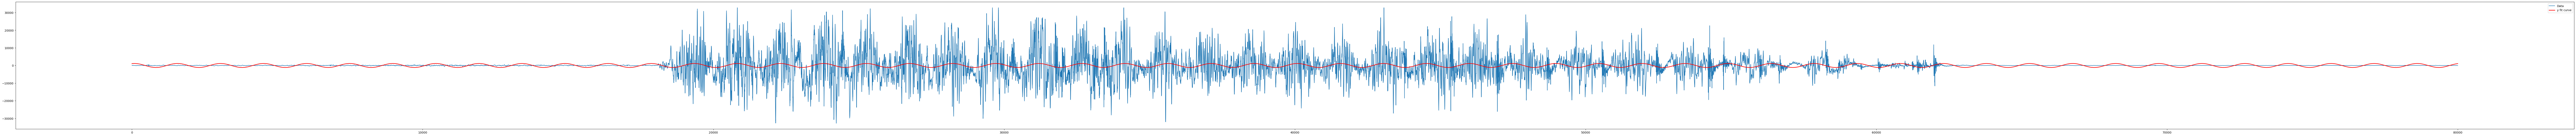

In [169]:

x_vals=np.linspace(0,len(one_sample)-1, num=len(one_sample))
x_vals_test=np.linspace(0,len(one_sample)-1, num=10* len(one_sample))

res = fit_sin(x_vals, one_sample)
print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )
plt.figure(figsize=(160, 8))
plt.plot(x_vals[:len(one_sample)], one_sample, label='Data')
plt.plot(x_vals_test, res["fitfunc"](x_vals_test), "r-", label="y fit curve", linewidth=2)
plt.legend(loc='best')
plt.show()

In [173]:
0.004241018146938535*40000
the_freq=res['omega']/(2*np.pi)
the_freq*40000

26.99916007310792

100 0
200 0
300 0
400 0
500 0
600 0
700 0
800 0
900 0


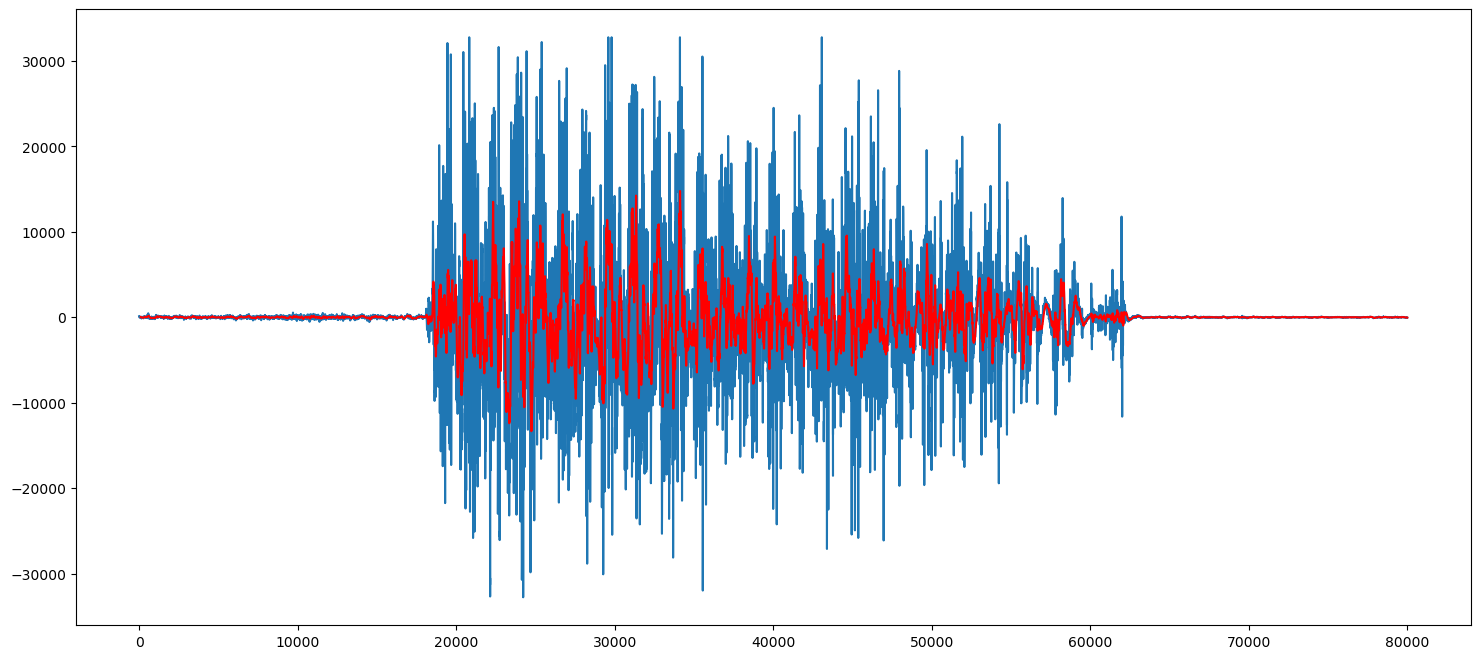

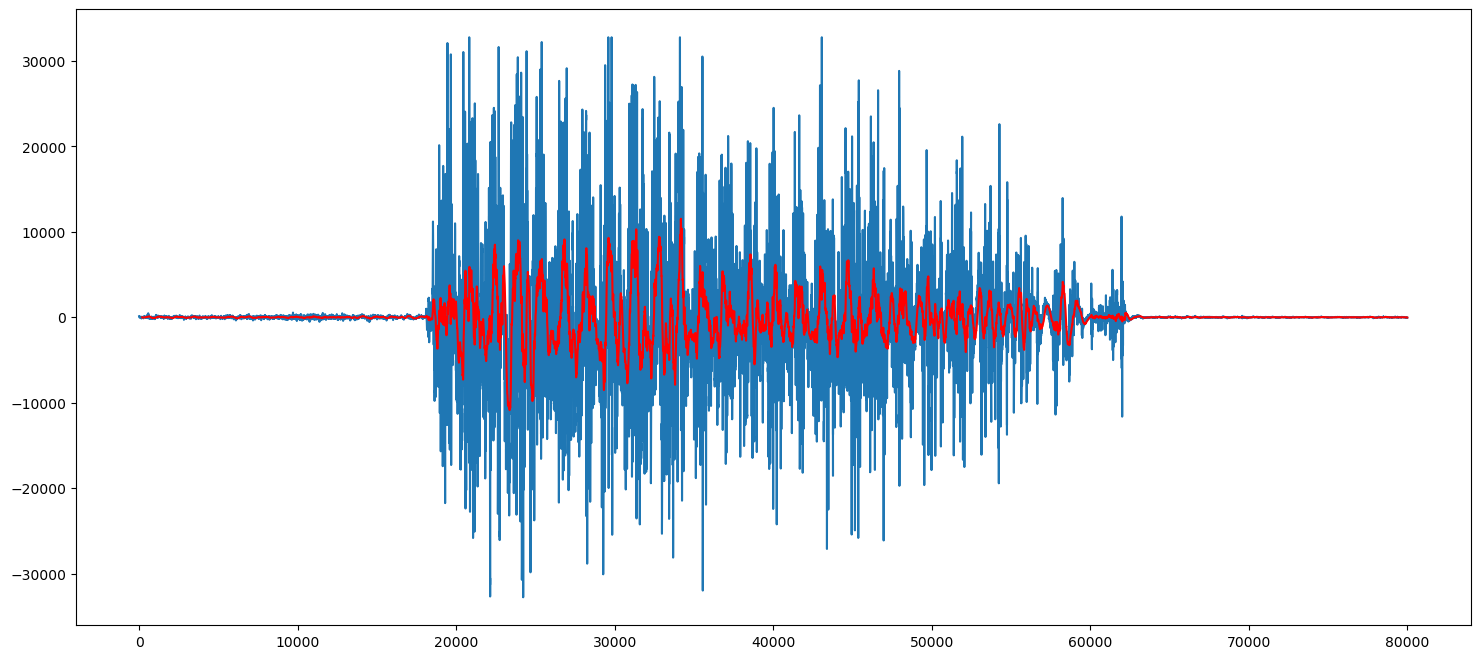

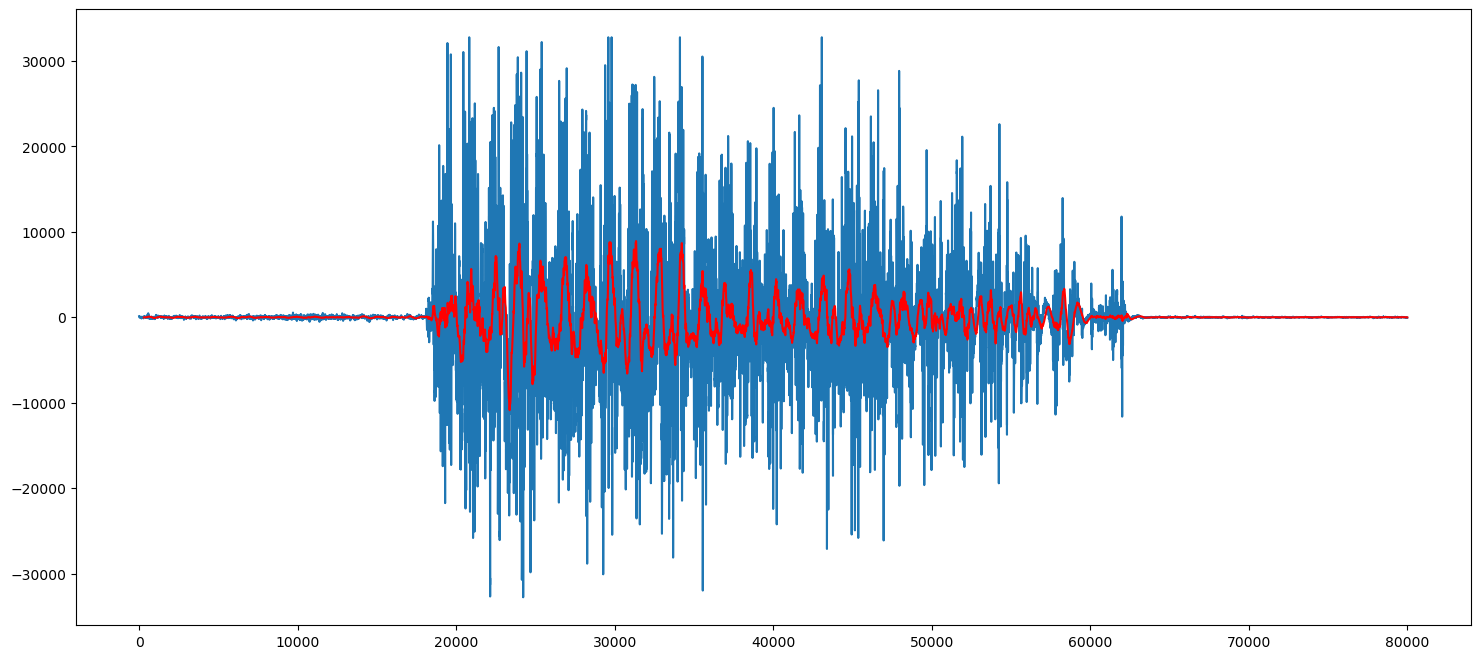

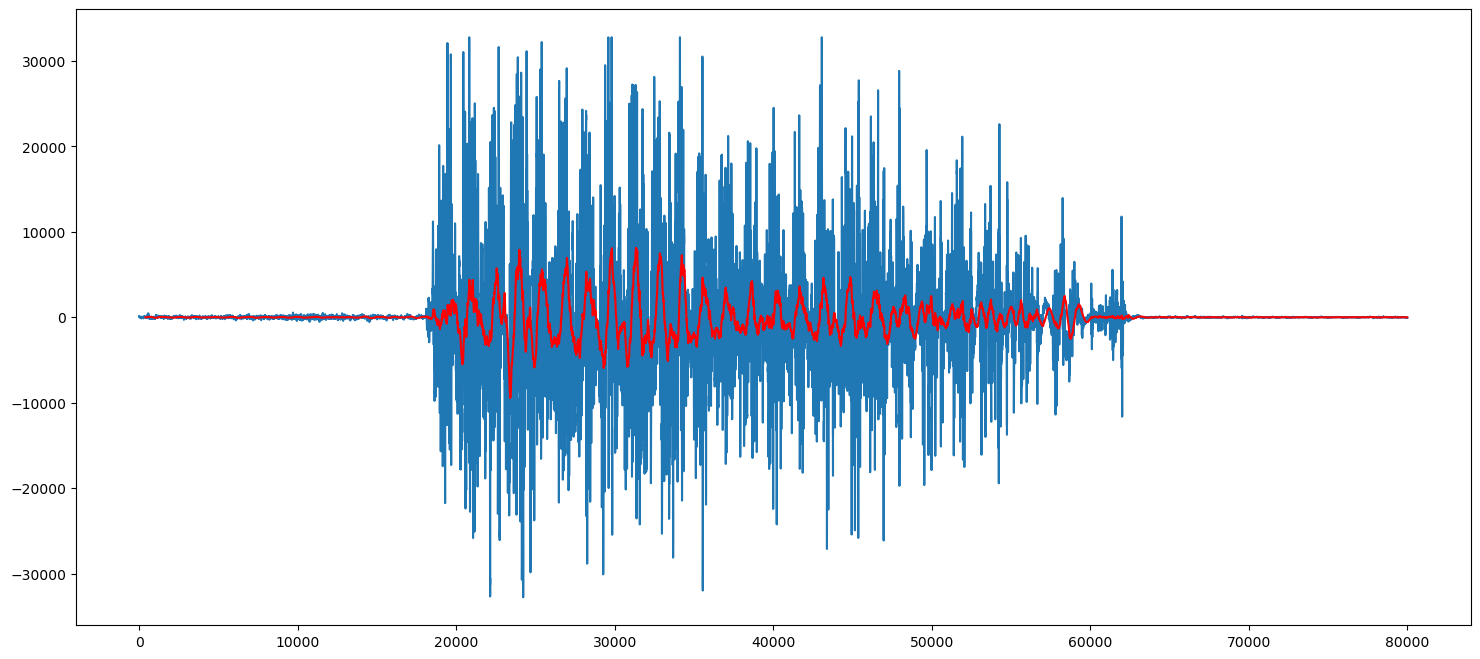

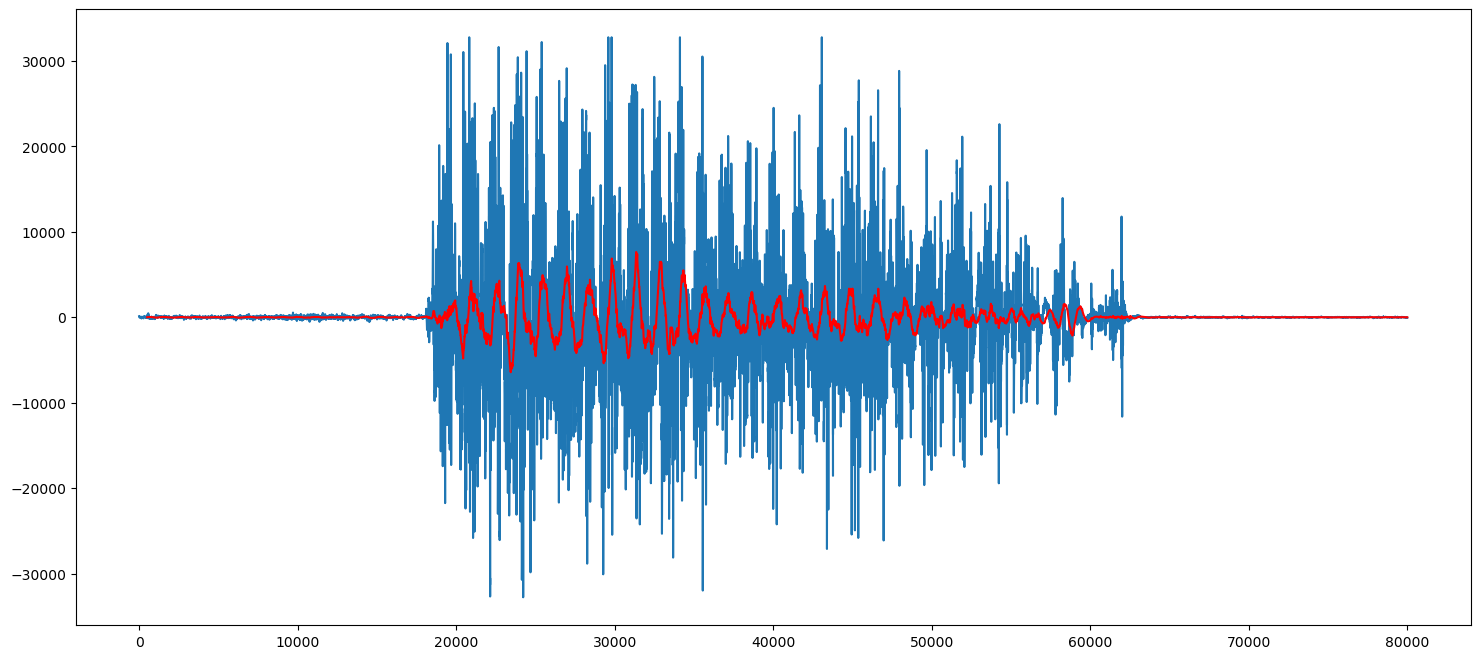

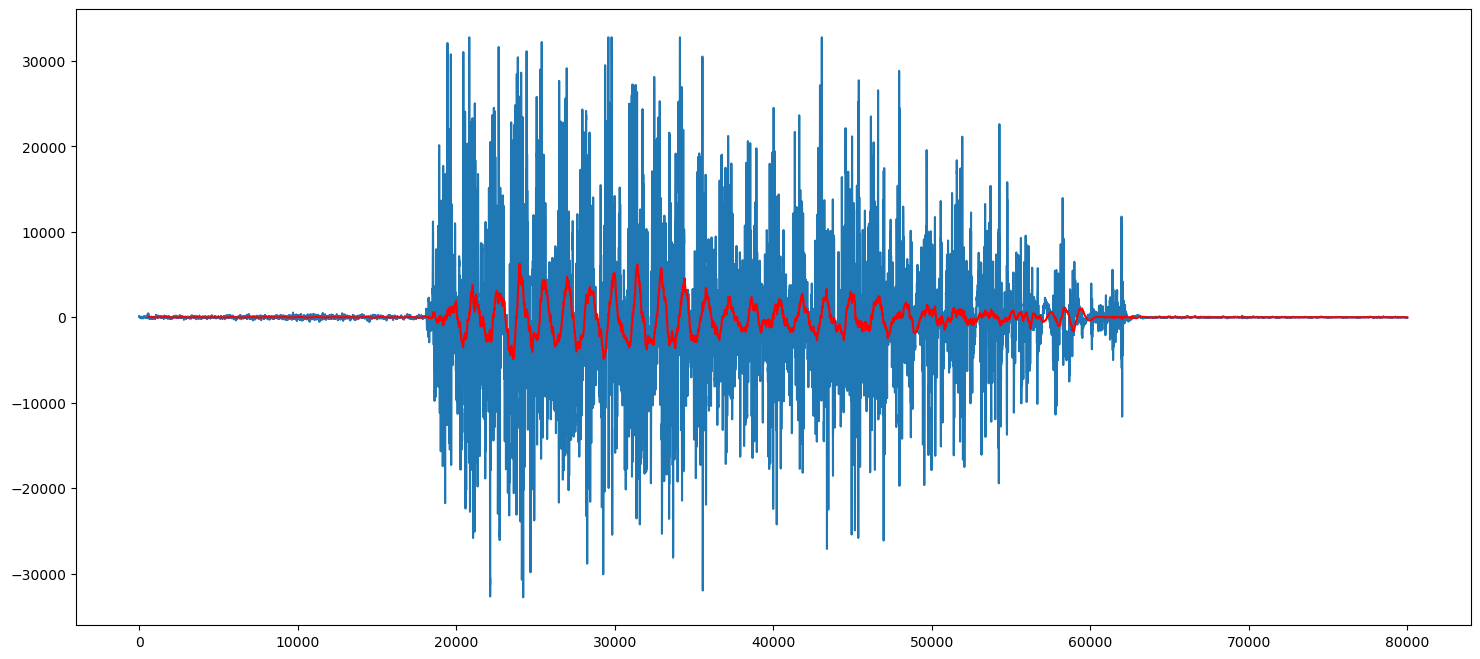

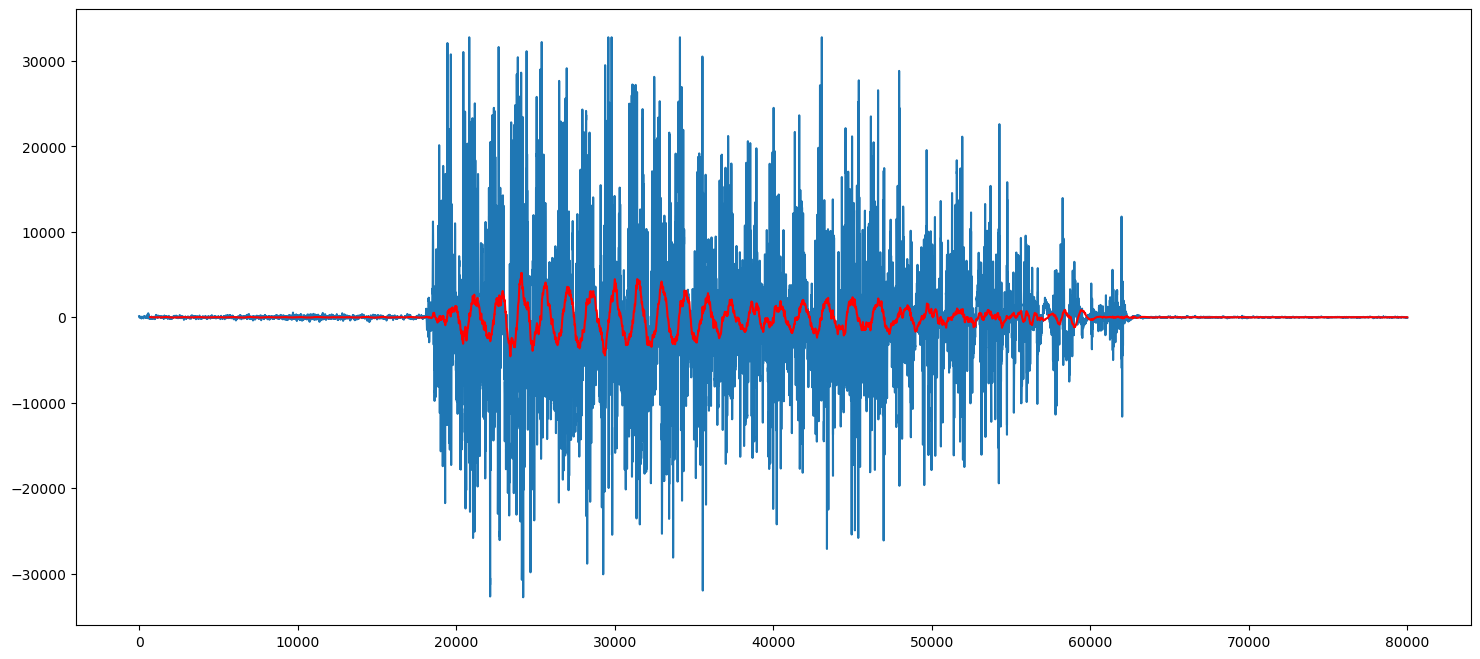

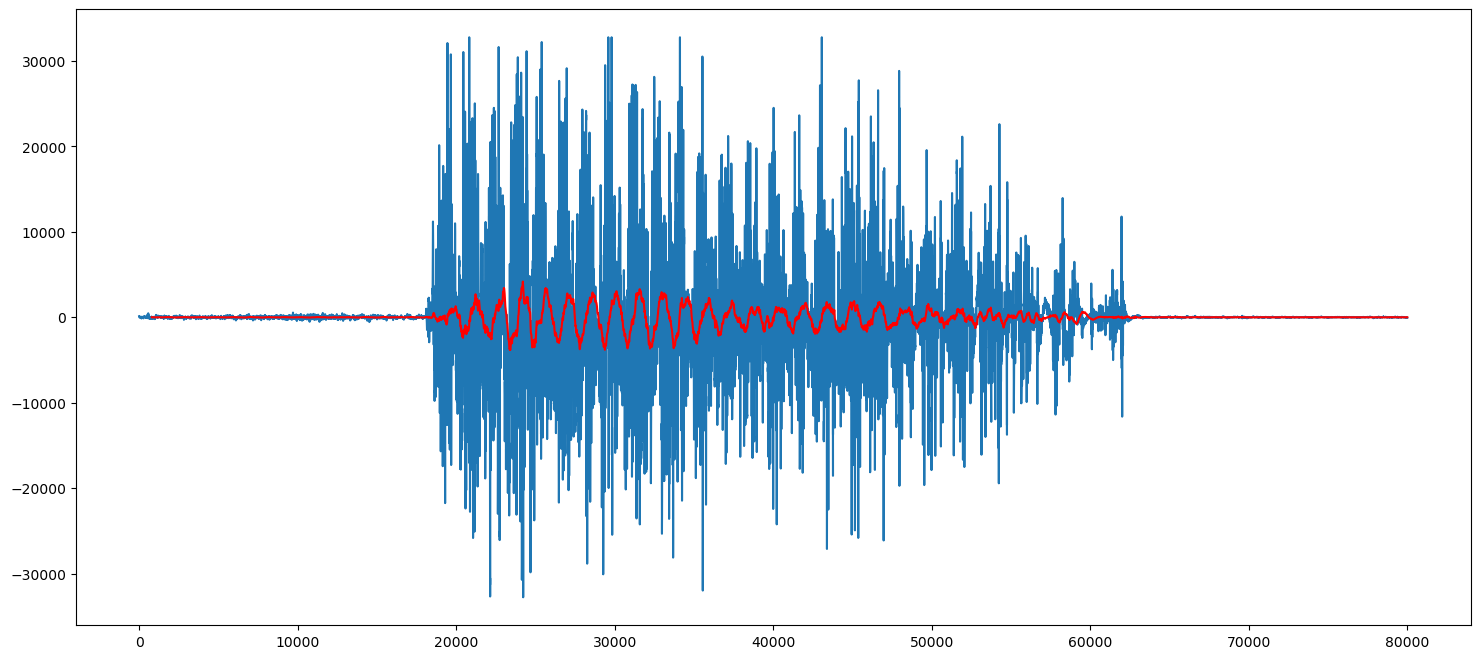

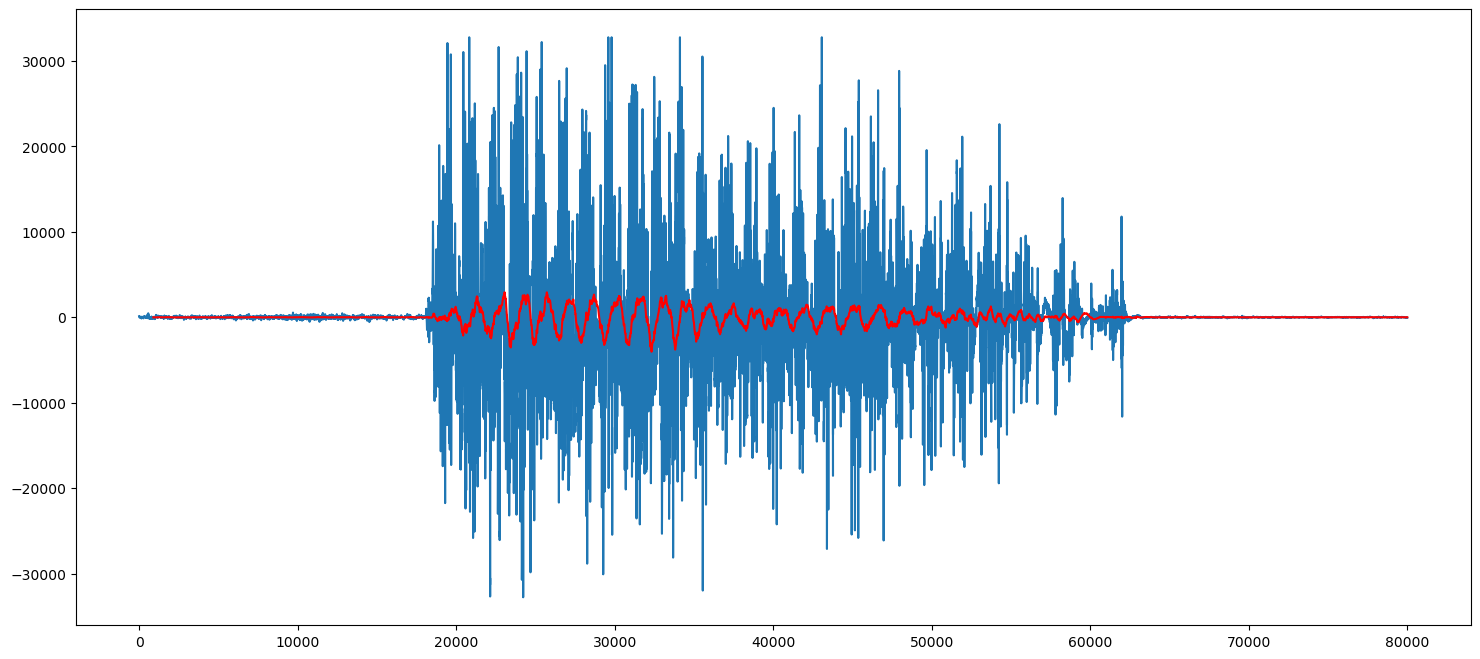

In [158]:
# one_sample=one_sample[10000:-10000]
smooth_window=1000
powz=1
one_sample_powz=list(one_sample).copy()
one_sample_powz=list(map(lambda x:pow(x,powz),one_sample_powz))
one_sample_series=pd.Series(one_sample_powz)
for smooth_window in range(100, 1000,100):

    one_sample_smooth1=one_sample_series.rolling(smooth_window).mean()
    plt.figure(figsize=[25,8])
    plt.plot(one_sample)
    plt.plot(one_sample_smooth1, color='r')
    ppeaks, _ = find_peaks(one_sample_smooth1)
    npeaks, _ = find_peaks(-one_sample_smooth1)
    all_peaks=list(ppeaks)+list(npeaks)
    all_peaks.sort()
    true_peaks=[]
    i=1
    for i in range(1,len(true_peaks)-1):
        if np.sign(one_sample_smooth1[all_peaks[i]])!= np.sign(one_sample_smooth1[all_peaks[i-1]]) and np.sign(one_sample_smooth1[all_peaks[i]])!= np.sign(one_sample_smooth1[all_peaks[i+1]]) :
            true_peaks.append(all_peaks[i])
    print(smooth_window, len(true_peaks))
# plt.plot(true_peaks, one_sample_smooth1[true_peaks], 'o', color='green')

Curve fitting: sine wave

[-12.60525539   1.00000661]


In [ ]:
plt.plot(test_ddd[1:100])

In [ ]:


powz=3
short_sound_list_powered=list(map(lambda x:pow(x,powz),short_sound_list))
short_sound_df=pd.Series(short_sound_list_powered)
short_sound_list_powered_smooth1=short_sound_df.rolling(500).mean()
plt.plot(short_sound_list_powered_smooth1,'+',color='g')
short_sound_list_powered_smooth2=short_sound_list_powered_smooth1.rolling(500).mean()
plt.plot(short_sound_list_powered_smooth1,'+',color='black')

# %%

slow_sound_lpf = speed_change(new_short_lpf, 0.1)
# play(slow_sound+20)
# %%
plt.figure(figsize=(12,7))
slow_sound_lpf_list=list(slow_sound_lpf.get_array_of_samples())
plt.plot(slow_sound)
# %%
file_handle = slow_sound_lpf.export("slow_sound_output.wav", format="wav")
# %%
slow_sound_list_df=pd.Series(slow_sound_lpf_list)
smooth1_slow_sound_list=slow_sound_list_df.rolling(10000).max()
smooth2_slow_sound_list=slow_sound_list_df.rolling(10000).min()
plt.figure(figsize=[15,5])
plt.plot(smooth1_slow_sound_list)
plt.plot(smooth2_slow_sound_list)
# plt.plot(slow_sound_list)
plt.show()

# %%
# peaks, _ = find_peaks(slow_sound_lpf_list, height=threshold, distance=min_distance_between_peaks)
maxAmp=max(slow_sound_list_df)
peaks, _ = find_peaks(slow_sound_lpf_list, height=0.5*maxAmp)
# %%
len(peaks)
# %%
# a positive peak is max between two negatives
peakpeak=[0]*len(slow_sound_list_df)
positives=[]
negatives=[]
for i in peaks:
    if slow_sound_list_df[i]<0:
        negatives.append((i, slow_sound_list_df[i]))
        # mark the peak
        if positives:
            aPair=max(positives, key=lambda item: item[1])
            print(aPair)
            peakpeak[aPair[0]]=aPair[1]
        positives=[]
    else:
        positives.append((i, slow_sound_list_df[i]))
        #negs
        if negatives:
            aPair=min(negatives, key=lambda item: item[1])
            peakpeak[aPair[0]]=aPair[1]
        negatives=[]
plt.figure(figsize=(20,7))
plt.plot(slow_sound_lpf_list)
plt.plot(peaks,slow_sound_list_df[peaks],'o', color='g')
plt.plot(peakpeak,'o',color='r')
sum([1 if i>0 else 0 for i in peakpeak])


# %%
peaks
# %% fitting sine wave

